In [1]:
import jax.numpy as np
import numpy as onp
from jax import grad, jit, vmap
from jax import random

import xaosim as xs
from xaosim.pupil import PHARO_MED_FULL as PHARO

import matplotlib.pyplot as plt

import astropy.io.fits as pf
from scipy.ndimage import rotate

from time import time as clock
import morphine
import xara

%matplotlib inline

import matplotlib as mpl
mpl.style.use('seaborn-colorblind')
phasemap = mpl.cm.rainbow
phasemap.set_bad(color='k')


#To make sure we have always the same matplotlib settings
#(the ones in comments are the ipython notebook settings)

mpl.rcParams['figure.figsize']=(12.0,9.0)    #(6.0,4.0)
mpl.rcParams['font.size']=20               #10 
mpl.rcParams['savefig.dpi']= 200             #72 
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
from matplotlib import rc
mpl.rcParams["font.family"] = "Times New Roman"

colours = mpl.rcParams['axes.prop_cycle'].by_key()['color']

from astropy import units as units

shift = np.fft.fftshift
fft   = np.fft.fft2
ifft  = np.fft.ifft2
fftfreq = np.fft.fftfreq

dtor = np.pi/180.0

import warnings
warnings.filterwarnings("ignore")

bit = 32
# bit = 64

if bit == 64:
    print('64 bit enabled')
    from jax.config import config; config.update("jax_enable_x64", True)


/Users/benjaminpope/opt/anaconda3/lib/python3.7/site-packages/pysynphot/locations.py:346: UserWarning: Extinction files not found in /Users/benjaminpope/pysynphot/grp/hst/cdbs/extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))
/Users/benjaminpope/opt/anaconda3/lib/python3.7/site-packages/pysynphot/refs.py:118: UserWarning: No graph or component tables found; functionality will be SEVERELY crippled. No files found for /Users/benjaminpope/pysynphot/grp/hst/cdbs/mtab/*_tmg.fits
  'functionality will be SEVERELY crippled. ' + str(e))
/Users/benjaminpope/opt/anaconda3/lib/python3.7/site-packages/pysynphot/refs.py:125: UserWarning: No thermal tables found, no thermal calculations can be performed. No files found for /Users/benjaminpope/pysynphot/grp/hst/cdbs/mtab/*_tmt.fits
  'no thermal calculations can be performed. ' + str(e))


## Example Code to illustrate Issue with Jit

###  I am encountering an `UnexpectedTracerError` when I try to Jit a function involving a core class in `morphine`, an optics simulation package built on Jax.  

First, simple stuff setting up an array - what does a telescope aperture look like? This is the Hale Telescope on Mt Palomar, California.

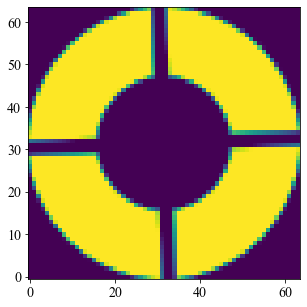

In [2]:
PSZ     =  64   # size of the array for the model
pdiam   = 4.646    # telescope diameter in meters

# pmask   = PHARO(PSZ, PSZ/2, mask="med")
oversample = 5
pmask  = PHARO(PSZ*(2**oversample), (2**oversample)*PSZ/2, mask="med", ang=-2) # rotated!
def half_bin(array):
    return (array[::2,::2] + array[1::2,::2] + array[::2,1::2] + array[1::2,1::2])/4.

for j in range(oversample):
    pmask = half_bin(pmask)
ppscale = pdiam / PSZ


# -------------------------
#      simple plot
# -------------------------
f0 = plt.figure(0)
f0.clf()
ax = f0.add_subplot(111)
ax.imshow(pmask)
f0.set_size_inches(5,5, forward=True)

#f0.savefig("./imgs/PHARO/rotated_pupil.png")
# -------------------------



Turn it into a class that `morphine` can use

In [3]:
pharo = morphine.ArrayOpticalElement(opd=np.zeros_like(pmask),
                               transmission=pmask,
                               pixelscale=ppscale,
                               name='pharo',planetype=1)
pharo.pupil_diam = pdiam

Initialize variables.

In [17]:
WAVELENGTH = 2.145e-6
RADIUS = pdiam/2. # meters
PIXSCALE = 0.025 # arcsec / pix
NWAVES = 1.0
ISZ = 64*16
FOV = ISZ*PIXSCALE # arcsec
NPIX = PSZ#96

Define a class to read this pupil in as a custom object in morphine - should I jit this? I think maybe it's something to do with `wavefront` being an attribute rather than its own object?

In [18]:
class mywavefront(morphine.ArrayOpticalElement):
    def __init__(self, wavelength, pupil, phasescreen, **kwargs):
        """ If your optic has adjustible parameters, then save them as attributes here """
        super().__init__()
        self.pupil = pupil
        self.wavelength = wavelength
        self.phasescreen = phasescreen

    def get_opd(self,wave):
        opd = self.phasescreen
        return opd

    def get_transmission(self, wave):
        transmission = self.pupil.get_transmission(wave)
        return transmission

    # behind the scenes morphine  will calculate:
    #    phasor = transmission = np.exp(1.j * 2 * np.pi / wave.wavelength * opd)


Initialize some objects.

In [19]:
osys = morphine.OpticalSystem(npix=PSZ)
osys.add_pupil(pharo)    # pupil radius in meters
osys.pupil_diameter = pdiam

wf = osys.input_wavefront()
wfe = mywavefront(WAVELENGTH,osys.planes[0],np.zeros_like(wf.coordinates()[0]))
osys.add_pupil(wfe)
osys.add_detector(pixelscale=PIXSCALE*2, fov_arcsec=FOV)

pupil = osys.planes[0]


wfe = mywavefront(WAVELENGTH,osys.planes[0],np.zeros_like(pmask))

This is what a perfect image of a star through this telescope and camera would look like.

In [20]:
%%timeit
psf,intermediate = osys.propagate_mono(WAVELENGTH)
# plt.imshow(psf.intensity**0.5)

65.5 ms ± 8.64 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [21]:
npup = 5 
np.float32(5)

DeviceArray(5., dtype=float32)

## Now let's reproduce the bug!

In [9]:
@jit
def psf_from_phasescreen(phasescreen,wavel=WAVELENGTH):
    osys = morphine.OpticalSystem(npix=PSZ)
    osys.add_pupil(pharo)
    osys.pupil_diameter = pdiam

    wf = osys.input_wavefront()
    wfe = mywavefront(wavel,osys.planes[0],phasescreen)
    osys.add_pupil(wfe)
    osys.add_detector(pixelscale=PIXSCALE*2, fov_arcsec=FOV)

    psf,intermediate = osys.propagate_mono(wavel)
    return psf,osys



In [10]:
zero_phase = np.zeros_like(wf.coordinates()[0])


In [11]:
@jit
def end_to_end_min(phasescreen):
    psf, osys = psf_from_phasescreen(phasescreen)
    return (psf.wavefront)

output0 = psf_from_phasescreen(zero_phase)
output05  = end_to_end_min(zero_phase)


UnexpectedTracerError: Encountered an unexpected tracer. Perhaps this tracer escaped through global state from a previously traced function.
The functions being transformed should not save traced values to global state.
Details: Can't lift sublevels 2 to 1.